# Forecasting solar flares using random forest
***


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, average_precision_score)
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [2]:
# Load raw dataframe
df = pd.read_csv("./Data/data_flares.csv")

print(df.info())
print(df.shape)
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5316 entries, 0 to 5315
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   DATE                        5316 non-null   object 
 1   USFLUX                      5316 non-null   float64
 2   MEANGAM                     5316 non-null   float64
 3   MEANGBT                     5316 non-null   float64
 4   MEANGBZ                     5316 non-null   float64
 5   MEANGBH                     5316 non-null   float64
 6   MEANJZD                     5316 non-null   float64
 7   TOTUSJZ                     5316 non-null   float64
 8   MEANALP                     5316 non-null   float64
 9   MEANJZH                     5316 non-null   float64
 10  TOTUSJH                     5316 non-null   float64
 11  ABSNJZH                     5316 non-null   float64
 12  SAVNCPP                     5316 non-null   float64
 13  MEANPOT                     5316 

# Changing the dataframe to fit random forest
***

In [3]:
# Convert boolean to integer (True -> 1, False -> 0)
df['flare_today'] = df['flare_today'].astype(int)
print(df.head())

ValueError: cannot convert float NaN to integer

In [ ]:
# Ensure the 'DATE' column is in datetime format
df['DATE'] = pd.to_datetime(df['DATE'])

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3860 entries, 0 to 3859
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   DATE                        3860 non-null   datetime64[ns, UTC]
 1   USFLUX                      3860 non-null   float64            
 2   MEANGAM                     3860 non-null   float64            
 3   MEANGBT                     3860 non-null   float64            
 4   MEANGBZ                     3860 non-null   float64            
 5   MEANGBH                     3860 non-null   float64            
 6   MEANJZD                     3860 non-null   float64            
 7   TOTUSJZ                     3860 non-null   float64            
 8   MEANALP                     3860 non-null   float64            
 9   MEANJZH                     3860 non-null   float64            
 10  TOTUSJH                     3860 non-null   float64         

In [ ]:
# Analyze flare distribution over time
# Number of C, M, and X flares per year

sum_columns = ['Flares: C', 'Flares: M', 'Flares: X']
df_flares = df.groupby(df['DATE'].dt.year)[sum_columns].agg(['sum'])
#df_flares = df_flares.reset_index()
print(df_flares)

# Number of days with M or X flares
yearly_flares = df.groupby(df['DATE'].dt.year)['flare_today'].agg(['sum', 'count', 'mean'])
print("\nDays with M or X flare distribution by year:")
print(yearly_flares)

     Flares: C Flares: M Flares: X
           sum       sum       sum
DATE                              
2010      88.0       8.0       0.0
2011    1199.0     111.0       8.0
2012    1330.0     129.0       7.0
2013    1357.0      99.0      12.0
2014    1798.0     208.0      16.0
2015    1377.0     125.0       2.0
2016     320.0      16.0       0.0
2017     244.0      40.0       4.0
2018      24.0       0.0       0.0
2019      32.0       0.0       0.0
2020      83.0       1.0       0.0
2021       0.0       0.0       0.0

Days with M or X flare distribution by year:
      sum  count      mean
DATE                      
2010    8    242  0.033058
2011   65    365  0.178082
2012   79    363  0.217631
2013   68    365  0.186301
2014  118    365  0.323288
2015   68    365  0.186301
2016   11    364  0.030220
2017   16    447  0.035794
2018    0    544  0.000000
2019    0    186  0.000000
2020    1    253  0.003953
2021    0      1  0.000000


In [ ]:
# Function to create the lagged features to be used in the random forest model

def create_lagged_features(df, n_days=3):
    """
    Create features using the last n_days of data to predict tomorrow's flare.
    """
    df = df.copy()
    df['DATE'] = pd.to_datetime(df['DATE'])
    df = df.sort_values('DATE').reset_index(drop=True)
    
    # Features to use (exclude DATE and target)
    feature_cols = [col for col in df.columns if col not in ['DATE', 'flare_today']]
    
    # Create lagged features for each of the past n_days
    lagged_df = pd.DataFrame()
    
    for i in range(1, n_days + 1):
        for col in feature_cols:
            lagged_df[f'{col}_lag{i}'] = df[col].shift(i)
    
    # Target: tomorrow's flare (shift flare_today by -1)
    lagged_df['target'] = df['flare_today'].shift(-1)
    lagged_df['DATE'] = df['DATE']
    
    # Drop rows with NaN (first n_days rows and last row)
    lagged_df = lagged_df.dropna()
    
    return lagged_df

In [ ]:
# Create the lagged features for the past 3 days
lagged_data = create_lagged_features(df, n_days=3)

print(lagged_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3856 entries, 3 to 3858
Data columns (total 92 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   USFLUX_lag1                      3856 non-null   float64            
 1   MEANGAM_lag1                     3856 non-null   float64            
 2   MEANGBT_lag1                     3856 non-null   float64            
 3   MEANGBZ_lag1                     3856 non-null   float64            
 4   MEANGBH_lag1                     3856 non-null   float64            
 5   MEANJZD_lag1                     3856 non-null   float64            
 6   TOTUSJZ_lag1                     3856 non-null   float64            
 7   MEANALP_lag1                     3856 non-null   float64            
 8   MEANJZH_lag1                     3856 non-null   float64            
 9   TOTUSJH_lag1                     3856 non-null   float64            
 10  ABSNJ

In [ ]:
# Separate features and target
X = lagged_data.drop(['target', 'DATE'], axis=1)
y = lagged_data['target']

In [ ]:
# Add date back temporarily for analysis
X_with_date = X.copy()
X_with_date['DATE'] = lagged_data['DATE'].values
X_with_date['target'] = y.values

In [ ]:
# Analyze flare distribution over time
yearly_flares = X_with_date.groupby(X_with_date['DATE'].dt.year)['target'].agg(['sum', 'count', 'mean'])
print("\nFlare distribution by year:")
print(yearly_flares)


Flare distribution by year:
        sum  count      mean
DATE                        
2010    8.0    239  0.033473
2011   65.0    365  0.178082
2012   79.0    363  0.217631
2013   69.0    365  0.189041
2014  117.0    365  0.320548
2015   69.0    365  0.189041
2016   10.0    364  0.027473
2017   16.0    447  0.035794
2018    0.0    544  0.000000
2019    0.0    186  0.000000
2020    1.0    253  0.003953


In [ ]:
# Strategy: Use years with good flare activity for both train and test
# Option 1: Use active years for train, hold out some active periods for test
flare_dates = X_with_date[X_with_date['target'] == 1]['DATE']
print(f"\nTotal days with flares: {len(flare_dates)}")
print(f"Date range with flares: {flare_dates.min()} to {flare_dates.max()}")


Total days with flares: 434
Date range with flares: 2010-05-04 00:00:00 to 2020-11-28 00:00:00


In [ ]:
# Option 2: Stratified split by time chunks (recommended)
# Split data into time chunks and sample from each
X_with_date = X_with_date.sort_values('DATE').reset_index(drop=True)

In [ ]:
# Use first 70% for train, next 15% for validation, last 15% for test
# But only from periods with flare activity
active_period = X_with_date[X_with_date['DATE'] < '2018-01-01']  # Before solar minimum
print(f"\nActive period samples: {len(active_period)}")
print(f"Active period flares: {active_period['target'].sum()} ({active_period['target'].mean()*100:.2f}%)")

if len(active_period) > 0 and active_period['target'].sum() > 10:
    # Use active period only
    split_idx1 = int(len(active_period) * 0.85)
    
    train_data = active_period.iloc[:split_idx1]
    test_data = active_period.iloc[split_idx1:]
    
    X_train = train_data.drop(['DATE', 'target'], axis=1)
    y_train = train_data['target']
    X_test = test_data.drop(['DATE', 'target'], axis=1)
    y_test = test_data['target']
    
    print(f"\nUsing only active solar period (before 2018)")
else:
    # Fallback: stratified sampling across all data
    from sklearn.model_selection import train_test_split
    X_no_date = X_with_date.drop(['DATE', 'target'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
        X_no_date, X_with_date['target'], 
        test_size=0.2, 
        stratify=X_with_date['target'],
        random_state=42
    )
    print(f"\nUsing stratified random split (maintains flare ratio)")

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"\nClass distribution in training set:")
print(y_train.value_counts())
print(f"Percentage of positive cases in train: {y_train.mean()*100:.2f}%")
print(f"\nClass distribution in test set:")
print(y_test.value_counts())
print(f"Percentage of positive cases in test: {y_test.mean()*100:.2f}%")



Active period samples: 2873
Active period flares: 433.0 (15.07%)

Using only active solar period (before 2018)

Training samples: 2442
Test samples: 431

Class distribution in training set:
target
0.0    2025
1.0     417
Name: count, dtype: int64
Percentage of positive cases in train: 17.08%

Class distribution in test set:
target
0.0    415
1.0     16
Name: count, dtype: int64
Percentage of positive cases in test: 3.71%


In [ ]:
# Split into train and test sets (chronological split is important for time series)
# Use last 20% as test set
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"\nClass distribution in training set:")
print(y_train.value_counts())
print(f"Percentage of positive cases in train: {y_train.mean()*100:.2f}%")
print(f"\nClass distribution in test set:")
print(y_test.value_counts())
print(f"Percentage of positive cases in test: {y_test.mean()*100:.2f}%")



Training samples: 3084
Test samples: 772

Class distribution in training set:
target
0.0    2651
1.0     433
Name: count, dtype: int64
Percentage of positive cases in train: 14.04%

Class distribution in test set:
target
0.0    771
1.0      1
Name: count, dtype: int64
Percentage of positive cases in test: 0.13%


In [ ]:
# Optional: Scale features (Random Forest doesn't require it, but doesn't hurt)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Apply SMOTE to balance the training data
print("\n" + "="*60)
print("APPLYING SMOTE TO BALANCE TRAINING DATA")
print("="*60)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"\nAfter SMOTE:")
print(f"Training samples: {len(X_train_balanced)}")
print(pd.Series(y_train_balanced).value_counts())

# Hyperparameter tuning with GridSearchCV
print("\n" + "="*60)
print("HYPERPARAMETER TUNING")
print("="*60)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample']
}


APPLYING SMOTE TO BALANCE TRAINING DATA

After SMOTE:
Training samples: 4050
target
1.0    2025
0.0    2025
Name: count, dtype: int64

HYPERPARAMETER TUNING


In [ ]:
# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# Pipeline: scale first, then train SVM
svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(probability=True, random_state=42, class_weight="balanced"))
])

# Define parameter grid
param_grid = {
    "svm__C": [0.1, 1, 10, 100],
    "svm__gamma": ["scale", 0.01, 0.001],
    "svm__kernel": ["rbf", "poly"]   # rbf is most common, but you can test poly or linear
}

# Grid search with cross-validation
grid_search = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid,
    cv=5,                # or use your custom cv
    scoring="roc_auc",   # same as with RF
    n_jobs=-1,           # speeds up CV folds, but not inside SVM itself
    verbose=1
)

print("\nStarting grid search for SVM (this may take a while)...")
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best AUC:", grid_search.best_score_)




Starting grid search (this may take a while)...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best parameters: {'class_weight': 'balanced_subsample', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation ROC-AUC: 0.8155


In [ ]:
# Train final model with best parameters on balanced data
print("\n" + "="*60)
print("TRAINING FINAL MODEL")
print("="*60)
best_rf = RandomForestClassifier(**grid_search.best_params_, random_state=42, n_jobs=-1)
best_rf.fit(X_train_balanced, y_train_balanced)


TRAINING FINAL MODEL


RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [ ]:
# Make predictions
y_pred = best_rf.predict(X_test_scaled)
y_pred_proba = best_rf.predict_proba(X_test_scaled)[:, 1]

In [ ]:
# Evaluation
print("\n" + "="*60)
print("MODEL EVALUATION ON TEST SET")
print("="*60)
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

if len(np.unique(y_test)) > 1:
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    print(f"\nROC-AUC Score: {roc_auc:.4f}")
    print(f"Average Precision Score: {avg_precision:.4f}")



MODEL EVALUATION ON TEST SET

Confusion Matrix:
[[771   0]
 [  1   0]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       771
         1.0       0.00      0.00      0.00         1

    accuracy                           1.00       772
   macro avg       0.50      0.50      0.50       772
weighted avg       1.00      1.00      1.00       772


ROC-AUC Score: 1.0000
Average Precision Score: 1.0000


c:\Users\fdesm\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\fdesm\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\fdesm\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20))


Top 20 Most Important Features:
                            feature  importance
27                   Flares: C_lag1    0.074403
17                  xrs_A_mean_lag1    0.055648
22                   xrs_B_max_lag1    0.053706
19                   xrs_A_max_lag1    0.047466
20                  xrs_B_mean_lag1    0.046406
23           Radio Flux 10.7cm_lag1    0.032694
57                   Flares: C_lag2    0.030103
47                  xrs_A_mean_lag2    0.026193
21                   xrs_B_min_lag1    0.025331
53           Radio Flux 10.7cm_lag2    0.021260
28                   Flares: M_lag1    0.019342
52                   xrs_B_max_lag2    0.017880
49                   xrs_A_max_lag2    0.017808
26                 New Regions_lag1    0.017588
87                   Flares: C_lag3    0.015377
50                  xrs_B_mean_lag2    0.015179
83           Radio Flux 10.7cm_lag3    0.015085
18                   xrs_A_min_lag1    0.014521
13                      TOTPOT_lag1    0.012863
25  Sun

In [ ]:
# Function to make predictions for new data
def predict_tomorrow_flare(model, scaler, last_3_days_data):
    """
    Predict if there will be a flare tomorrow based on last 3 days.
    
    Parameters:
    -----------
    model: trained RandomForestClassifier
    scaler: fitted StandardScaler
    last_3_days_data: DataFrame with 3 rows (most recent day first)
    
    Returns:
    --------
    prediction: 0 (no flare) or 1 (flare)
    probability: probability of flare
    """
    # Create lagged features manually
    features = []
    for i, row in enumerate(last_3_days_data.iterrows(), 1):
        for col in row[1].index:
            if col not in ['DATE', 'flare_today']:
                features.append(row[1][col])
    
    X_new = np.array(features).reshape(1, -1)
    X_new_scaled = scaler.transform(X_new)
    
    prediction = model.predict(X_new_scaled)[0]
    probability = model.predict_proba(X_new_scaled)[0][1]
    
    return prediction, probability

In [ ]:
# Example usage:
# last_3_days = df.tail(3).sort_values('DATE', ascending=False)
# prediction, prob = predict_tomorrow_flare(best_rf, scaler, last_3_days)
# print(f"Prediction: {'Flare expected' if prediction == 1 else 'No flare expected'}")
# print(f"Probability: {prob:.2%}")

In [ ]:
# Example usage:
last_3_days = df.tail(3).sort_values('DATE', ascending=False)
prediction, prob = predict_tomorrow_flare(best_rf, scaler, last_3_days)
print(f"Prediction: {'Flare expected' if prediction == 1 else 'No flare expected'}")
print(f"Probability: {prob:.2%}")

Prediction: No flare expected
Probability: 5.40%


c:\Users\fdesm\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Visualization saved as 'solar_flare_results.png'


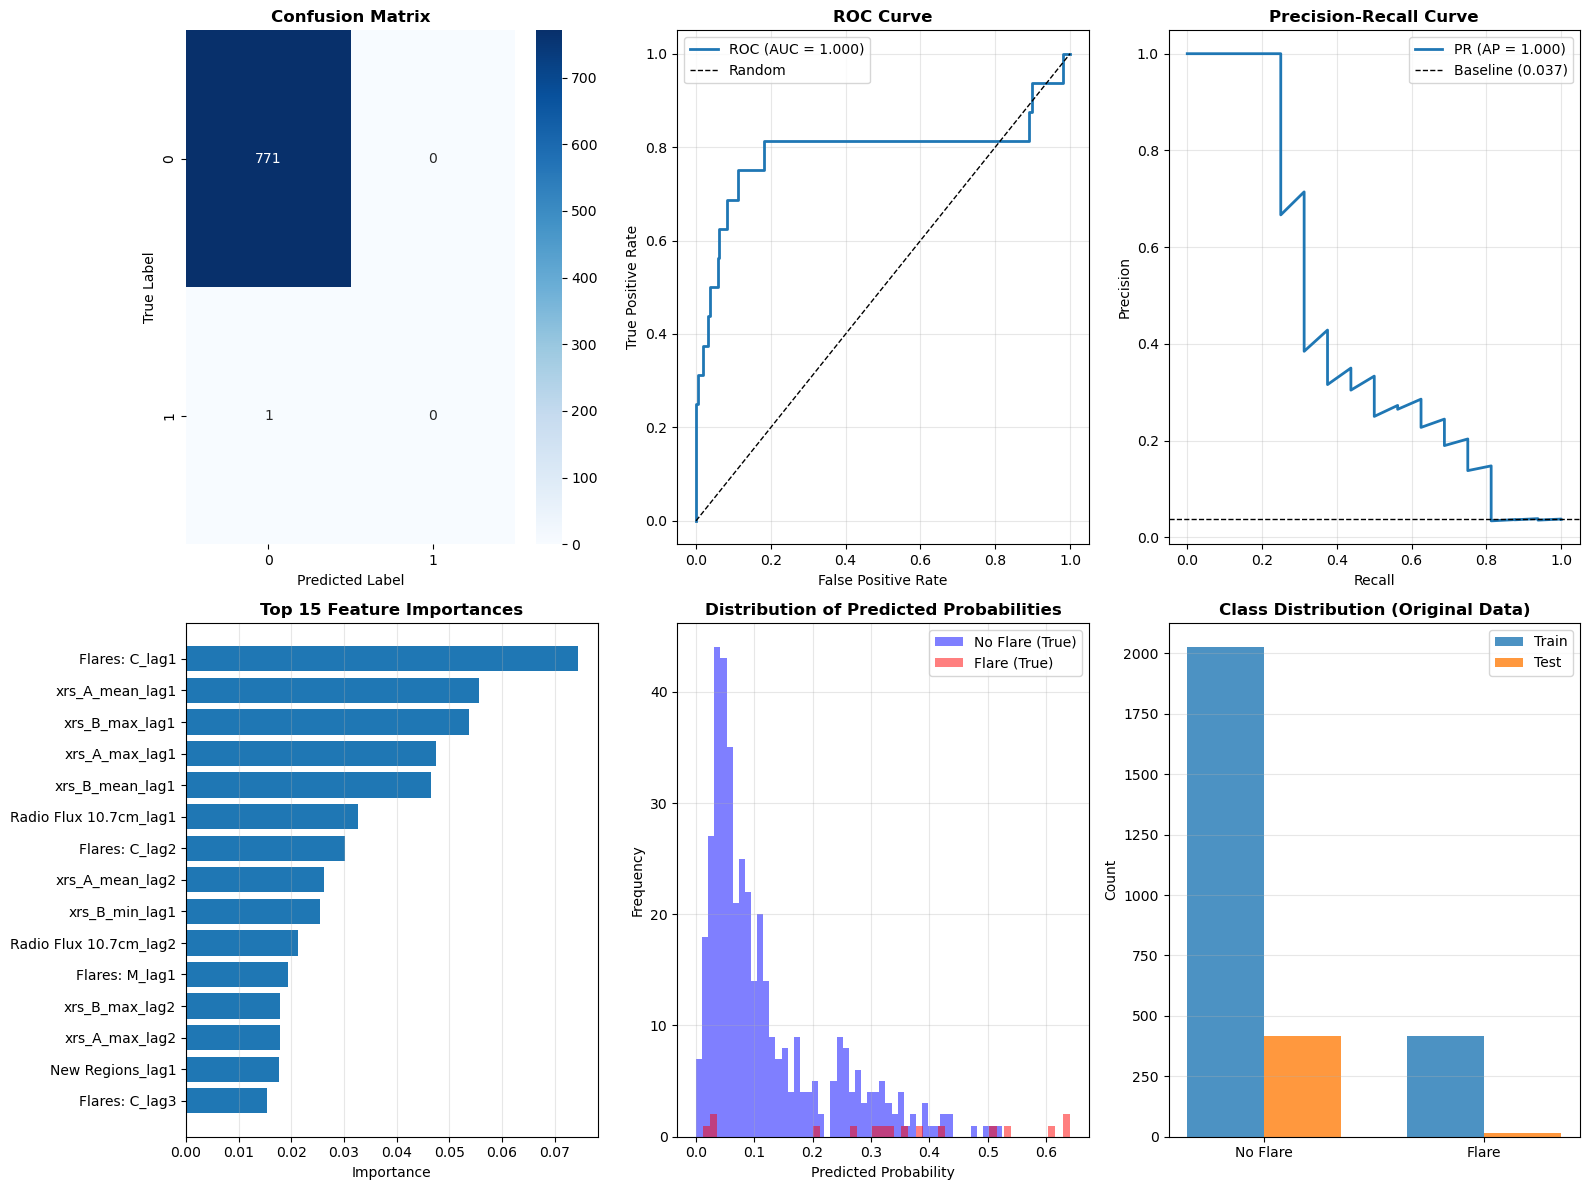

In [ ]:
fig = plt.figure(figsize=(16, 12))

# 1. Confusion Matrix
ax1 = plt.subplot(2, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Confusion Matrix', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

# 2. ROC Curve
if len(np.unique(y_test)) > 1:
    ax2 = plt.subplot(2, 3, 2)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax2.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
    ax2.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

# 3. Precision-Recall Curve
if len(np.unique(y_test)) > 1:
    ax3 = plt.subplot(2, 3, 3)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    ax3.plot(recall, precision, linewidth=2, label=f'PR (AP = {avg_precision:.3f})')
    ax3.axhline(y=y_test.mean(), color='k', linestyle='--', linewidth=1, 
                label=f'Baseline ({y_test.mean():.3f})')
    ax3.set_xlabel('Recall')
    ax3.set_ylabel('Precision')
    ax3.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

# 4. Feature Importance (Top 15)
ax4 = plt.subplot(2, 3, 4)
top_features = feature_importance.head(15)
ax4.barh(range(len(top_features)), top_features['importance'])
ax4.set_yticks(range(len(top_features)))
ax4.set_yticklabels(top_features['feature'])
ax4.invert_yaxis()
ax4.set_xlabel('Importance')
ax4.set_title('Top 15 Feature Importances', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

# 5. Prediction Probability Distribution
ax5 = plt.subplot(2, 3, 5)
ax5.hist(y_pred_proba[y_test == 0], bins=50, alpha=0.5, label='No Flare (True)', color='blue')
ax5.hist(y_pred_proba[y_test == 1], bins=50, alpha=0.5, label='Flare (True)', color='red')
ax5.set_xlabel('Predicted Probability')
ax5.set_ylabel('Frequency')
ax5.set_title('Distribution of Predicted Probabilities', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Class Distribution
ax6 = plt.subplot(2, 3, 6)
train_dist = [sum(y_train == 0), sum(y_train == 1)]
test_dist = [sum(y_test == 0), sum(y_test == 1)]
x = np.arange(2)
width = 0.35
ax6.bar(x - width/2, train_dist, width, label='Train', alpha=0.8)
ax6.bar(x + width/2, test_dist, width, label='Test', alpha=0.8)
ax6.set_ylabel('Count')
ax6.set_title('Class Distribution (Original Data)', fontsize=12, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(['No Flare', 'Flare'])
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('solar_flare_results.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'solar_flare_results.png'")
plt.show()

In [ ]:
print("\n" + "="*60)
print("THRESHOLD ANALYSIS")
print("="*60)
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    cm_thresh = confusion_matrix(y_test, y_pred_thresh)
    tn, fp, fn, tp = cm_thresh.ravel() if cm_thresh.size == 4 else (cm_thresh[0,0], 0, 0, 0)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    print(f"\nThreshold = {thresh}")
    print(f"  TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
    print(f"  Precision: {precision:.3f}, Recall: {recall:.3f}")


THRESHOLD ANALYSIS

Threshold = 0.3
  TP: 11, FP: 36, TN: 379, FN: 5
  Precision: 0.234, Recall: 0.688

Threshold = 0.4
  TP: 6, FP: 10, TN: 405, FN: 10
  Precision: 0.375, Recall: 0.375

Threshold = 0.5
  TP: 5, FP: 3, TN: 412, FN: 11
  Precision: 0.625, Recall: 0.312

Threshold = 0.6
  TP: 3, FP: 0, TN: 415, FN: 13
  Precision: 1.000, Recall: 0.188

Threshold = 0.7
  TP: 0, FP: 0, TN: 415, FN: 16
  Precision: 0.000, Recall: 0.000
